In [1]:
import pandas as pd
from gqlalchemy import Memgraph
from tqdm import tqdm
import numpy as np
from matplotlib import pyplot as plt
import pickle

import networkx as nx
import tnetwork as tn
import tnetwork.DCD.externals
from sklearn.preprocessing import OneHotEncoder

from scipy.sparse import csr_matrix, vstack, hstack
from scipy.sparse.linalg import norm
import scipy

import Levenshtein as levenshtein

from pymongo import MongoClient
from networkx.algorithms.similarity import optimize_graph_edit_distance as oged

sim = "calcium"


In [25]:
def get_mongo_db():
    client = MongoClient("mongodb://localhost:27017")
    db = client[sim]["level_0_edges"]
    return db

db = get_mongo_db()


In [8]:
cursor = db.find({"step": 1_000_000}, {"_id": 0, "edge_id": 0})

synapses = {}
for synapse in tqdm(cursor, total=720_092):
    edge = tuple(sorted((synapse["from_id"], synapse["to_id"])))
    synapses[edge] = synapses.get(edge, {"source": synapse["from_id"], "target": synapse["to_id"]}) | {f"t{synapse['step'] // 10000}": synapse["weight"]}

df = pd.DataFrame.from_dict(synapses, orient="index")
# df.rename(columns={"t100": "weight"}, inplace=True)
df.reindex()
df

100%|██████████| 720092/720092 [00:03<00:00, 190197.60it/s]


,,source,target,t100
2,469,469,2,1
3,400,400,3,1
5,1008,1008,5,1
6,347,347,6,1
8,624,624,8,1
...,...,...,...,...
48041,49863,48041,49863,1
49446,49862,49446,49862,1
49855,49863,49855,49863,1
48410,49863,48410,49863,1


In [20]:
for i in range(101):
    if f"t{i}" not in df.columns:
        df[f"t{i}"] = np.nan

df

,,source,target,t4,t5,t6,t7,t8,t9,t10,t11,...,t95,t96,t97,t98,t99,t100,t0,t1,t2,t3
27,756,756,27,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,...,1.0,1.0,1.0,1.0,1.0,1.0,NaN,NaN,NaN,NaN
32,1542,1542,32,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
65,2246,2246,65,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
75,90,75,90,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,...,1.0,1.0,1.0,1.0,1.0,1.0,NaN,NaN,NaN,NaN
124,751,751,124,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
44921,49836,44921,49836,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,1.0,NaN,NaN,NaN,NaN
49757,49844,49757,49844,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,1.0,NaN,NaN,NaN,NaN
48680,49845,48680,49845,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,1.0,NaN,NaN,NaN,NaN
49799,49846,49799,49846,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,1.0,NaN,NaN,NaN,NaN


In [12]:
def get_graph_for_timestep(df, timestep: int):
    graph = nx.Graph()
    # 5k instead of 50k because we only care about the blobs
    graph.add_nodes_from(range(5_000))

    blob_edges: dict[tuple[int, int], int] = {}

    df = df[["source", "target", f"t{timestep}"]].copy()
    df.rename(columns={f"t{timestep}": "weight"}, inplace=True)
    for _, row in tqdm(df.iterrows(), total=720092):
        if not np.isnan(row.weight):
            edge = tuple(sorted((row.source // 10, row.target // 10)))
            blob_edges[edge] = blob_edges.get(edge, 0) + row.weight

    for (source, target), weight in blob_edges.items():
        if not np.isnan(weight):
            graph.add_edge(source, target, weight=weight)

    return graph

# DG = tn.DynGraphSN()
timesteps = 101
# for t in tqdm(range(0, timesteps)):
t = 100
G = get_graph_for_timestep(df, t)
# df_t = df[["source", "target", f"t{t}"]].copy()
# df_t.rename(columns={f"t{t}": "weight"}, inplace=True)
# nxG = nx.from_pandas_edgelist(df_t[["source", "target", "weight"]], "source", "target", "weight", create_using=nx.Graph)
# DG.add_snapshot(t, nxG)

100%|█████████▉| 716997/720092 [00:20<00:00, 35608.62it/s]


In [14]:
with open("last_step_no_network.pickle", "wb") as f:
    pickle.dump(G, f)

In [22]:
with open(f"dynamic_graph_full_{sim}.pickle", mode="wb") as file:
    pickle.dump(DG, file)

In [4]:
# with open(f"dynamic_graph_no_network.pickle", mode="rb") as file:
#     DG_NN = pickle.load(file)

with open(f"dynamic_graph_no_network.pickle", mode="rb") as file:
    DG = pickle.load(file)

In [39]:
remove_edges = set()
for t in tqdm(range(101)):
    snap = DG.snapshots(t)
    for edge in snap.edges():
        if np.isnan(snap[edge[0]][edge[1]]["weight"]) or snap[edge[0]][edge[1]]["weight"] == 0:
            remove_edges.add((t, edge))



100%|██████████| 101/101 [16:39<00:00,  9.90s/it] 


In [44]:
import sys, os

class HiddenPrints:
    def __enter__(self):
        self._original_stdout = sys.stdout
        sys.stdout = open(os.devnull, 'w')

    def __exit__(self, exc_type, exc_val, exc_tb):
        sys.stdout.close()
        sys.stdout = self._original_stdout

for t, edge in tqdm(remove_edges):
    with HiddenPrints():
        DG.remove_interaction(edge[0], edge[1], t)

100%|██████████| 53895231/53895231 [16:47<00:00, 53506.14it/s] 


In [5]:
for i, e in enumerate(DG.snapshots(9).edges(data=True)):
    if np.isnan(e[2]["weight"]):
        print(e)
        print("NOOOO")
        break

747640
747488
0


In [6]:

def size_difference(G1, G2):
    return (len(G2.edges()) - len(G1.edges()))


def pad_sparse_matrix(A, ideal_shape):
    A = vstack([A, csr_matrix((ideal_shape[0] - A.shape[0], A.shape[1]))], format="csr")
    A = hstack([A, csr_matrix((A.shape[0], ideal_shape[1] - A.shape[1]))], format="csr")
    return A

import time
def L2(G1, G2):
    t1 = time.time()
    A1 = nx.to_scipy_sparse_array(G1)
    A2 = nx.to_scipy_sparse_array(G2)
    print("to_scipy_sparse_array", time.time() - t1)

    t1 = time.time()
    # pad with zeros to shape
    ideal_shape = (5000, 5000)  
    A1 = pad_sparse_matrix(A1, ideal_shape)
    A2 = pad_sparse_matrix(A2, ideal_shape)
    print("pad_sparse_matrix", time.time() - t1)

    t1 = time.time()
    n = norm(A1 - A2)
    print("norm", time.time() - t1)

    return n
def L2_k(G1, G2, k=2):
    A1 = csr_matrix(nx.adjacency_matrix(G1))
    A2 = csr_matrix(nx.adjacency_matrix(G2))

    # pad with zeros to shape    
    ideal_shape = (5000, 5000)
    A1 = pad_sparse_matrix(A1, ideal_shape)
    A2 = pad_sparse_matrix(A2, ideal_shape)

    return norm(A1**k - A2**k)


def kl_divergence(p, q):
    vec = scipy.special.rel_entr(p, q)
    vec = np.ma.masked_invalid(vec).compressed()
    kl_div = np.sum(vec)    
    return kl_div

def pagerank_kl_divergence(G1, G2):
    pr1 = nx.pagerank(G1)
    pr2 = nx.pagerank(G2)

    # pad with zeros to shape
    pr1 = np.pad(list(pr1.values()), ((0, 50000 - len(pr1))), 'constant')
    pr2 = np.pad(list(pr2.values()), ((0, 50000 - len(pr2))), 'constant')

    # calculate kl divergence
    kl_div = kl_divergence(pr1, pr2)

    return 1 - kl_div


def stability(DG, metric, delta=1):
    values = []
    for i in tqdm(range(0, len(DG.snapshots_timesteps()) - delta)):
        G1 = DG.snapshots(i)
        G2 = DG.snapshots(i + delta)
        score = metric(G1, G2)
        values.append(score)
    print("max", max(values))
    return [x for x in values]


metrics = {
    "L2": L2,
    # "L2_2": lambda x, y: L2_k(x, y, k=2),
    # "L2_3": lambda x, y: L2_k(x, y, k=3),
    # "pagerank_kl_divergence": pagerank_kl_divergence,
    # "Graph edit distance": lambda G1, G2: next(oged(G1, G2))
    # "Size difference": size_difference
}

scores = {}

# for name, metric in metrics.items():
    # scores[name] = stability(DG, metric, delta=1)

stability(DG, L2, delta=1)

# scores_c = {}

# for name, metric in metrics.items():
#     scores_c[name + " Calcium"] = stability(DG_C, metric)

100%|██████████| 100/100 [11:25<00:00,  6.85s/it]

max 332.9249164601532


In [39]:
edges_count_calcium = []
for t in tqdm(range(101)):
    count = db.count_documents({"step": t * 10000, "weight": {"$gt": 0}})
    edges_count_calcium.append(count)
print(str(edges_count_calcium))


100%|██████████| 101/101 [00:52<00:00,  1.93it/s]

[720092, 720092, 720092, 720092, 720092, 686220, 692703, 690179, 689547, 689101, 688264, 686574, 684931, 682757, 680215, 677326, 673790, 664607, 656680, 651045, 644617, 639553, 634409, 628656, 626298, 624955, 623698, 617044, 606487, 598094, 590930, 586447, 581062, 579817, 577054, 574075, 572265, 570298, 564709, 557409, 554663, 551677, 550447, 546642, 545181, 541692, 539456, 536023, 531778, 527995, 527175, 527369, 526464, 523340, 518652, 516394, 515574, 514405, 512303, 510520, 507195, 503463, 499788, 496442, 494766, 493050, 490628, 488345, 485935, 484625, 484794, 483995, 481996, 479999, 477989, 475664, 473671, 471527, 470203, 467952, 466141, 464492, 463355, 461678, 460016, 458067, 456981, 456199, 454599, 452639, 450670, 449796, 448659, 447643, 446678, 445700, 444650, 443832, 442582, 441748, 441693]


In [99]:
edges_count_no_network = edges_count

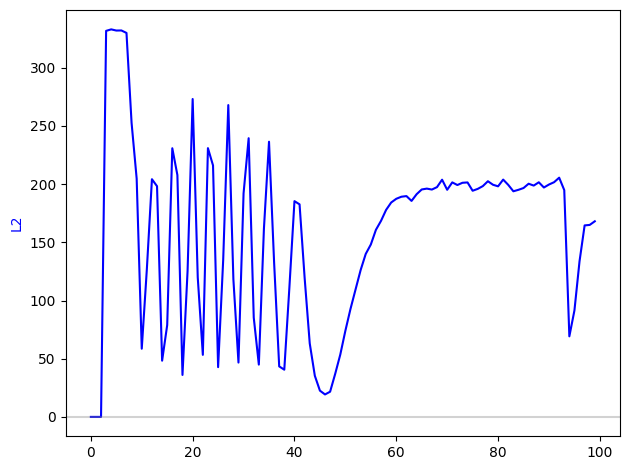

In [7]:
def align_yaxis(ax1, ax2):
    """Align zeros of the two axes, zooming them out by same ratio"""
    axes = (ax1, ax2)
    extrema = [ax.get_ylim() for ax in axes]
    tops = [extr[1] / (extr[1] - extr[0]) for extr in extrema]
    # Ensure that plots (intervals) are ordered bottom to top:
    if tops[0] > tops[1]:
        axes, extrema, tops = [list(reversed(l)) for l in (axes, extrema, tops)]

    # How much would the plot overflow if we kept current zoom levels?
    tot_span = tops[1] + 1 - tops[0]

    b_new_t = extrema[0][0] + tot_span * (extrema[0][1] - extrema[0][0])
    t_new_b = extrema[1][1] - tot_span * (extrema[1][1] - extrema[1][0])
    axes[0].set_ylim(extrema[0][0], b_new_t)
    axes[1].set_ylim(t_new_b, extrema[1][1])

fig, ax1 = plt.subplots()
ax1.plot(scores["L2"], label="L2 Calcium",  color="blue")
ax1.set_ylabel("L2", color="blue")
# ax1.set_ylim(0, 850000)
# ax2 = ax1.twinx()
# ax2.plot(scores["Size difference"], label="Edge count Calcium first derivative", color="red")
# ax2.set_ylabel("Edge count first derivative", color="red")

# plt.ylim(-12000, 20000)

# align_yaxis(ax1, ax2)
# plt.legend()
# plt.grid()
plt.axhline(y=0, color='gray', linestyle='-', alpha=0.35)
# plt.show()
# plt.plot(stability_scores)
# plt.show()
plt.tight_layout()
plt.savefig(f"L2_calcium_blobbed_delta_2.png")

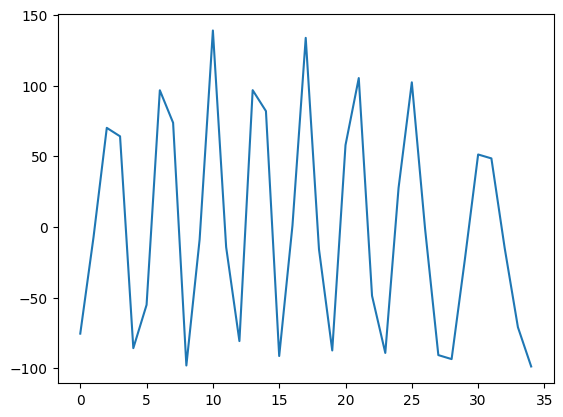

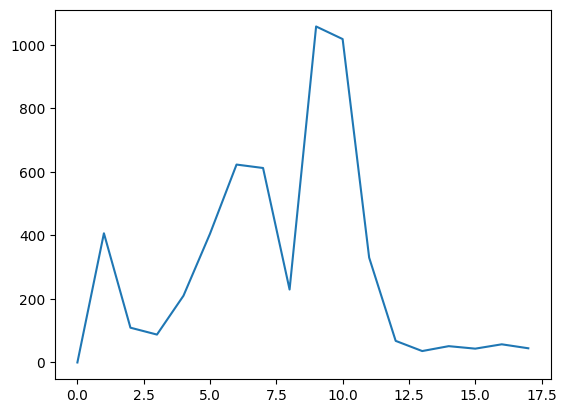

In [36]:
from scipy.fft import rfft, rfftfreq

score = scores["L2"][10:45]
score = score - np.mean(score)
plt.plot(score)
plt.show()
xf = rfftfreq(len(score), 1 / len(score))
yf = rfft(score)

plt.plot(xf, np.abs(yf))
plt.show()


In [37]:
communities = tnetwork.DCD.smoothed_louvain(DG)

  0% (0 of 101) |                        | Elapsed Time: 0:00:00 ETA:  --:--:--


starting smoothed_louvain


  3% (4 of 101) |                        | Elapsed Time: 0:00:01 ETA:   0:00:26
  4% (5 of 101) |#                       | Elapsed Time: 0:00:03 ETA:   0:00:58
  5% (6 of 101) |#                       | Elapsed Time: 0:00:04 ETA:   0:02:44
  6% (7 of 101) |#                       | Elapsed Time: 0:00:06 ETA:   0:02:18
  7% (8 of 101) |#                       | Elapsed Time: 0:00:07 ETA:   0:02:20
  8% (9 of 101) |##                      | Elapsed Time: 0:00:10 ETA:   0:04:57
  9% (10 of 101) |##                     | Elapsed Time: 0:00:12 ETA:   0:03:42
 10% (11 of 101) |##                     | Elapsed Time: 0:00:14 ETA:   0:02:33
 11% (12 of 101) |##                     | Elapsed Time: 0:00:15 ETA:   0:02:27
 12% (13 of 101) |##                     | Elapsed Time: 0:00:17 ETA:   0:02:18
 13% (14 of 101) |###                    | Elapsed Time: 0:00:19 ETA:   0:03:34
 14% (15 of 101) |###                    | Elapsed Time: 0:00:21 ETA:   0:02:48
 15% (16 of 101) |###                   

In [66]:
def flip_partitioning(partitioning):
    nodes = [item for sublist in partitioning.values() for item in sublist]
    return dict(zip(nodes, map(lambda x: next(int(k) for k in partitioning.keys() if x in partitioning[k]), nodes)))

def number_of_births_or_deaths(G1, G2, C1, C2):
    C1 = flip_partitioning(C1)
    C2 = flip_partitioning(C2)
    return len(set(C2.values()) ^ set(C1.values()))

def estrangement(G1, G2, C1, C2):
    C1 = flip_partitioning(C1)
    C2 = flip_partitioning(C2)
    estranged = 0

    G1edges = G1.edges()

    for edge in G2.edges():
        if edge not in G1edges:
            # edges that are not in G1 are not estranged
            continue
        if C1[edge[0]] != C1[edge[1]]:
            # only edges that connected nodes in the same community can be estranged
            continue
        if C2[edge[0]] != C2[edge[1]]:
            estranged += 1
    if len(G2.edges()) == 0:
        return np.nan
    return estranged / len(G2.edges())


def lev(s, t):
    m, n = len(s), len(t)
    
    v0 = np.arange(n + 1)
    v1 = np.zeros(n + 1)
    
    for i in range(m):

        v1[0] = i + 1

        for j in range(n):

            deletion_cost = v0[j + 1] + 1
            insertion_cost = v1[j] + 1
            if s[i] == t[j]:
                substitution_cost = v0[j]
            else:
                substitution_cost = v0[j] + 1

            v1[j + 1] = min(deletion_cost, insertion_cost, substitution_cost)

        v0, v1 = v1, v0
    return v0[n] / max(m, n)

def levenshtein_stability(G1, G2, C1, C2):
    C1 = flip_partitioning(C1)
    C2 = flip_partitioning(C2)

    # get values sorted by key
    a = [C1[k] for k in sorted(C1.keys())]
    b = [C2[k] for k in sorted(C2.keys())]

    if min(len(a), len(b)) == 0:
        return np.nan

    return levenshtein.distance(a, b) / max(len(a), len(b))

def cosine_similarity(a, b):
    return np.dot(a, b) / (np.linalg.norm(a) * np.linalg.norm(b))

def cosine_similarity_stability(G1, G2, C1, C2):
    C1 = flip_partitioning(C1)
    C2 = flip_partitioning(C2)

    # get values sorted by key
    a = [C1[k] for k in sorted(C1.keys())]
    b = [C2[k] for k in sorted(C2.keys())]

    if min(len(a), len(b)) == 0:
        return np.nan
    # pad with zeros to get same length
    if len(a) < len(b):
        a = np.pad(a, (0, len(b) - len(a)), 'constant')
    elif len(b) < len(a):
        b = np.pad(b, (0, len(a) - len(b)), 'constant')
    

    # one hot encode
    categories = np.unique(np.concatenate((a, b)))
    encoder = OneHotEncoder(categories=[categories])
    a = encoder.fit_transform(np.array(a).reshape(-1, 1)).toarray().flatten()
    b = encoder.fit_transform(np.array(b).reshape(-1, 1)).toarray().flatten()

    return cosine_similarity(a, b)


def community_stability(DG, communities, metric, measures_instability=False, **kwargs):
    values = []
    plot = kwargs.get("plot", False)
    if plot:
        fig, axs = plt.subplots(7, 5, figsize=(16, 12))
        axs = axs.flatten()
    for i in tqdm(range(1, len(DG.snapshots_timesteps()))):
        G1 = DG.snapshots(i - 1)
        G2 = DG.snapshots(i)
        C1 = communities.snapshots[i - 1]
        C2 = communities.snapshots[i]
        if plot:
            score = metric(G1, G2, C1, C2, axs[i-1], **kwargs)
        else:
            score = metric(G1, G2, C1, C2, **kwargs)
        values.append(score)
    if plot:
        for i in range(len(DG.snapshots_timesteps())-1, len(axs)):
            axs[i].axis('off')
        plt.tight_layout()
        plt.show()
    if measures_instability:
        # return values
        return [1 - x for x in values]
    else:
        return values
    
metrics = {
    "births or deaths": (number_of_births_or_deaths, False),  # ~1 second
    "levenshtein": (levenshtein_stability, True),  # ~1 second for the brain
    "estrangement": (estrangement, True),  # ~20 seconds
    "cosine similarity": (cosine_similarity_stability, False),  # ~1 second
}
community_scores = {}
for name, (metric, instability) in metrics.items():
    community_scores[name] = community_stability(DG, communities, metric, measures_instability=instability)

100%|██████████| 100/100 [00:00<00:00, 119.74it/s]


In [59]:

C1 = flip_partitioning(communities.snapshots[3])
C2 = flip_partitioning(communities.snapshots[4])
print()

9


[0, 0, 0, 9, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]
[nan, nan, nan, nan, 0.902, 0.9522, 0.9782, 0.9818, 0.981, 0.9942, 0.9984, 0.9978, 0.9968, 0.9892, 0.9986, 0.9976, 0.993, 0.9928, 1.0, 0.9886, 0.9956, 0.9972, 1.0, 0.9934, 0.997, 1.0, 0.9976, 0.9974, 0.9992, 0.9992, 0.9956, 0.997, 0.9988, 0.9996, 0.997, 0.998, 0.9948, 0.997, 0.9996, 0.9984, 0.9984, 0.995, 0.9998, 0.9992, 1.0, 1.0, 1.0, 1.0, 0.9998, 0.9998, 0.9998, 0.9994, 0.9996, 0.9994, 0.9992, 1.0, 0.9994, 0.9982, 0.9902, 0.9974, 0.9984, 0.9978, 0.9948, 0.9898, 0.9966, 0.9984, 0.9942, 0.9918, 0.997, 0.9986, 0.9962, 0.9978, 0.9984, 0.996, 0.997, 0.9968, 0.999, 0.9984, 0.9982, 0.9984, 0.998, 0.9948, 0.9988, 0.9972, 0.9894, 0.9984, 0.9924, 0.9976, 0.9942, 0.9986, 0.9958, 0.993, 0.998, 0.999,

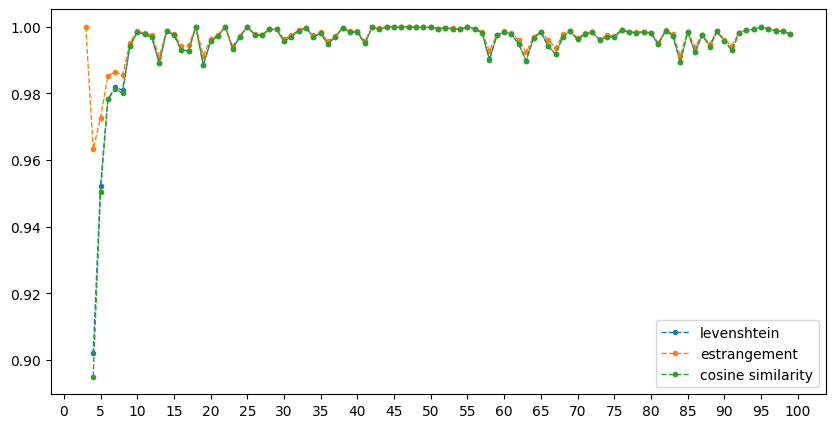

In [68]:
fig, ax = plt.subplots(figsize=(10, 5))


for name, score in community_scores.items():
    print(score)
    if name == "births or deaths":
        continue
    ax.plot(score, label=name, alpha=1, linestyle="--", marker="o", markersize=3, linewidth=1)
# ax.plot(summary_scores, label="summary_distance")
# plt.plot(community_scores, label="levenshtein_stability")
# plt.ylim((0, 1.1))

plt.legend()
# plt.grid()
ax.set_xticks(range(0, len(DG.snapshots_timesteps()), 5))
# plt.plot(stability_scores)
plt.savefig(f"{sim}_stability_louvain.png")
plt.show()

In [76]:
updates = []
for timestep, partitioning in communities.snapshots.items():
    if not partitioning:
        next_partitioning = None
        t = timestep
        while not next_partitioning:
            t += 1
            next_partitioning = communities.snapshots.get(t)
        updates.append((timestep, next_partitioning))

for timestep, next_partitioning in updates:
    communities.snapshots[timestep] = next_partitioning

In [87]:
def partition_communities(communities):
    DGs = {}
    for timestep, partitioning in communities.snapshots.items():
        G_snapshot = DG.snapshots(timestep)

        for community, nodes in partitioning.items():
            DynGraph = DGs.setdefault(int(community), tn.DynGraphSN())
            G = G_snapshot.subgraph(nodes)
            DynGraph.add_snapshot(timestep, G)
    return DGs

DGs = partition_communities(communities)


In [93]:
DGs

{1: <tnetwork.dyn_graph.dyn_graph_sn.DynGraphSN at 0x1eed917a770>,
 2: <tnetwork.dyn_graph.dyn_graph_sn.DynGraphSN at 0x1eed917bf10>,
 3: <tnetwork.dyn_graph.dyn_graph_sn.DynGraphSN at 0x1eed917bee0>,
 4: <tnetwork.dyn_graph.dyn_graph_sn.DynGraphSN at 0x1eed917a8c0>,
 5: <tnetwork.dyn_graph.dyn_graph_sn.DynGraphSN at 0x1eed9178640>,
 6: <tnetwork.dyn_graph.dyn_graph_sn.DynGraphSN at 0x1eed9178550>,
 7: <tnetwork.dyn_graph.dyn_graph_sn.DynGraphSN at 0x1eed917ba30>,
 8: <tnetwork.dyn_graph.dyn_graph_sn.DynGraphSN at 0x1eed9179f30>,
 9: <tnetwork.dyn_graph.dyn_graph_sn.DynGraphSN at 0x1eed9179d20>}

In [99]:
com = 4
subpartition = tnetwork.DCD.smoothed_louvain(DGs[com])

  0% (0 of 101) |                        | Elapsed Time: 0:00:00 ETA:  --:--:--


starting smoothed_louvain


  3% (4 of 101) |                        | Elapsed Time: 0:00:00 ETA:   0:00:03
  5% (6 of 101) |#                       | Elapsed Time: 0:00:00 ETA:   0:00:05
  6% (7 of 101) |#                       | Elapsed Time: 0:00:00 ETA:   0:00:06
  7% (8 of 101) |#                       | Elapsed Time: 0:00:00 ETA:   0:00:06
  8% (9 of 101) |##                      | Elapsed Time: 0:00:00 ETA:   0:00:08
  9% (10 of 101) |##                     | Elapsed Time: 0:00:01 ETA:   0:00:09
 10% (11 of 101) |##                     | Elapsed Time: 0:00:01 ETA:   0:00:09
 11% (12 of 101) |##                     | Elapsed Time: 0:00:01 ETA:   0:00:09
 12% (13 of 101) |##                     | Elapsed Time: 0:00:01 ETA:   0:00:10
 13% (14 of 101) |###                    | Elapsed Time: 0:00:01 ETA:   0:00:10
 14% (15 of 101) |###                    | Elapsed Time: 0:00:01 ETA:   0:00:10
 15% (16 of 101) |###                    | Elapsed Time: 0:00:02 ETA:   0:00:10
 16% (17 of 101) |###                   

In [100]:
metrics = {
    "births or deaths": (number_of_births_or_deaths, False),  # ~1 second
    "levenshtein": (levenshtein_stability, True),  # ~1 second for the brain
    "estrangement": (estrangement, True),  # ~20 seconds
    "cosine similarity": (cosine_similarity_stability, False),  # ~1 second
}
community_scores = {}
for name, (metric, instability) in metrics.items():
    community_scores[name] = community_stability(DGs[com], subpartition, metric, measures_instability=instability)


100%|██████████| 100/100 [00:00<00:00, 751.98it/s]


[0, 0, 0, 4, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]
[nan, nan, nan, nan, 0.7278225806451613, 0.9415322580645161, 0.9407114624505929, 0.962890625, 0.950381679389313, 0.9790076335877863, 0.9980879541108987, 0.9980842911877394, 0.9904580152671756, 0.9713740458015268, 0.9923809523809524, 0.9943074003795066, 0.9810246679316889, 0.9606003752345216, 1.0, 0.9962616822429906, 0.9888268156424581, 0.9981378026070763, 1.0, 0.960820895522388, 0.8752327746741154, 1.0, 0.9888268156424581, 0.987012987012987, 0.9981447124304267, 1.0, 0.9925788497217068, 0.9683426443202979, 0.9684014869888475, 1.0, 0.9925788497217068, 0.9981481481481481, 0.9944444444444445, 0.9981447124304267, 0.9981447124304267, 0.992619926199262, 0.994475138121547, 0.992633517495396, 0.9981

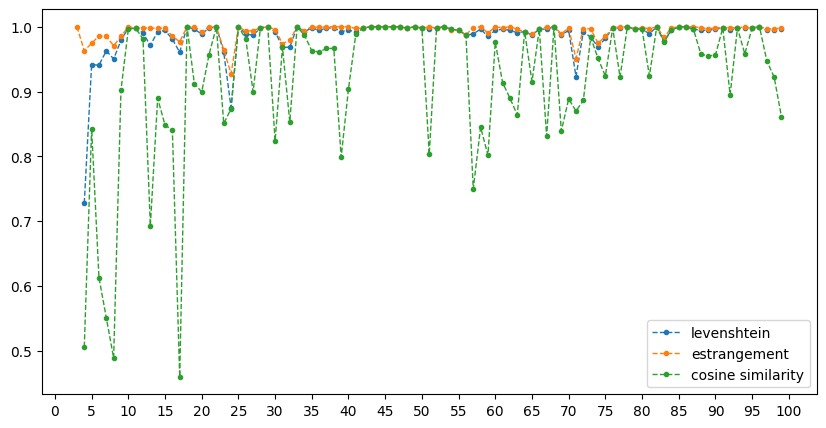

In [101]:
fig, ax = plt.subplots(figsize=(10, 5))


for name, score in community_scores.items():
    print(score)
    if name == "births or deaths":
        continue
    ax.plot(score, label=name, alpha=1, linestyle="--", marker="o", markersize=3, linewidth=1)
# ax.plot(summary_scores, label="summary_distance")
# plt.plot(community_scores, label="levenshtein_stability")
# plt.ylim((0, 1.1))

plt.legend()
# plt.grid()
ax.set_xticks(range(0, len(DG.snapshots_timesteps()), 5))
# plt.plot(stability_scores)
# plt.savefig(f"{sim}_stability_louvain.png")
plt.show()